Tworzymy syntetyczne zbiory

In [750]:
import sklearn.model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeClassifier
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import pandas as pd



index = 254460
seed = index
n_samples = 2560


syn_1_x, syn_1_t = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=seed)
syn1_train_x, syn1_test_x, syn1_train_t, syn1_test_t = train_test_split(syn_1_x, syn_1_t, test_size=.2, random_state=seed)
scaler = preprocessing.MinMaxScaler()
syn1_train_x = scaler.fit_transform(syn1_train_x)
syn1_test_x = scaler.fit_transform(syn1_test_x)
syn1_train_t = np.array([-1 if t == 0 else t for t in syn1_train_t])
syn1_test_t = np.array([-1 if t == 0 else t for t in syn1_test_t])
syn1_test_x_k1 = syn1_test_x[syn1_test_t == 1]
syn1_test_x_k2 = syn1_test_x[syn1_test_t == -1]


In [751]:
num_rows = syn1_test_x.shape[0]
ones_column = np.ones((num_rows, 1))
X_test = np.hstack((ones_column, syn1_test_x))

Klasyfikacji z Sklearn

In [752]:
clf = RidgeClassifier(alpha=1.0).fit(syn1_train_x, syn1_train_t)
syn1_test_y = clf.predict(syn1_test_x)
b = clf.intercept_
A_S = -clf.coef_[0][0]/clf.coef_[0][1]
B_S = -b/clf.coef_[0][1]
xs_S = np.array([0, 1])
ys_S = xs_S*A_S+B_S
teta_S = [clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]]

result_S = X_test@teta_S
print(result_S.shape)

syn1_test_y_S = [-1 if res <= 0 else 1 for res in result_S]

(512,)


Klasyfikacja analityczna

In [753]:
ALFA = 1.0

num_rows = syn1_train_x.shape[0]
ones_column = np.ones((num_rows, 1))
X = np.hstack((ones_column, syn1_train_x))
d = X.shape[1]
A = ALFA*np.identity(d)
teta_A = np.linalg.inv(X.T@X+A)@X.T@syn1_train_t
print(teta_A)
A_A = -teta_A[1]/teta_A[2]
B_A = -teta_A[0]/ teta_A[2]
xs_A = np.array([0, 1])
ys_A = xs_A*A_A+B_A

syn1_test_y_A = []
result_A = X_test@teta_A
print(result_A.shape)

syn1_test_y_A = [-1 if res <= 0 else 1 for res in result_A]



[ 1.74368114 -0.57717174 -3.74419752]
(512,)


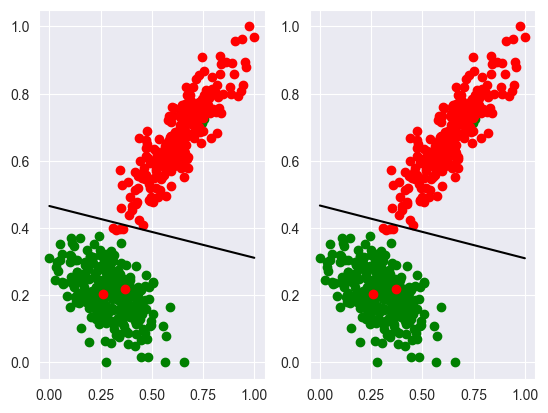

In [754]:
plt.subplot(1, 2, 1)
plt.scatter(syn1_test_x_k1[:,0], syn1_test_x_k1[:,1], c = "g")
plt.scatter(syn1_test_x_k2[:,0], syn1_test_x_k2[:,1], c = "r")
plt.plot(xs_A, ys_A, c="black")

plt.subplot(1, 2, 2)
plt.scatter(syn1_test_x_k1[:,0], syn1_test_x_k1[:,1], c = "g")
plt.scatter(syn1_test_x_k2[:,0], syn1_test_x_k2[:,1], c = "r")
plt.plot(xs_S, ys_S, c="black")
plt.show()


Macierz pomyłek sklearn

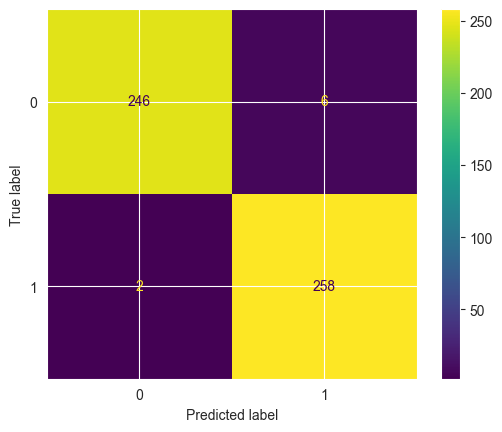

In [755]:
cm_S = confusion_matrix(syn1_test_t, syn1_test_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

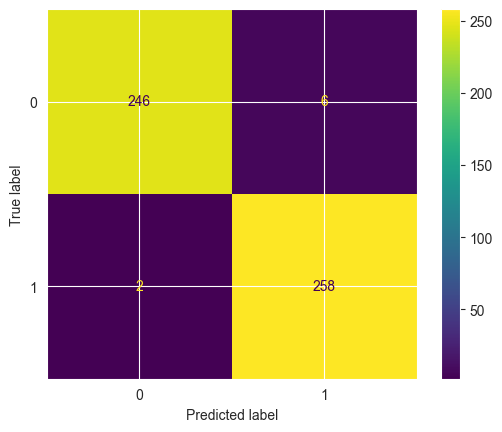

In [756]:
cm_A = confusion_matrix(syn1_test_t, syn1_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [757]:
TP = cm_S[1, 1]  # True Positive
FN = cm_S[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TP = cm_A[1, 1]  # True Positive
FN = cm_A[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TN = cm_S[0, 0]  # True Negative
FP = cm_S[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

TN = cm_A[0, 0]  # True Negative
FP = cm_A[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)


0.9923076923076923
0.9923076923076923
0.9761904761904762
0.9761904761904762


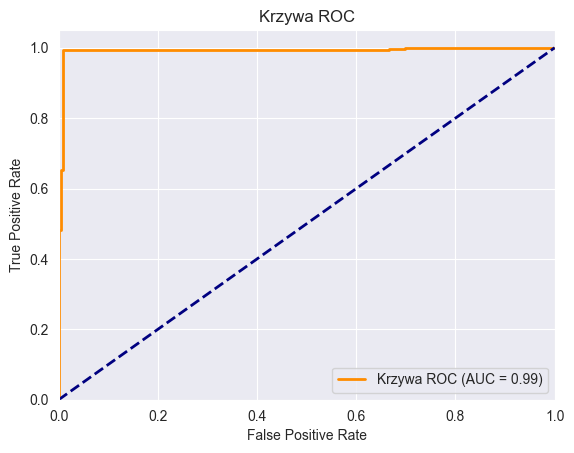

In [758]:
fpr, tpr, thresholds = roc_curve(syn1_test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

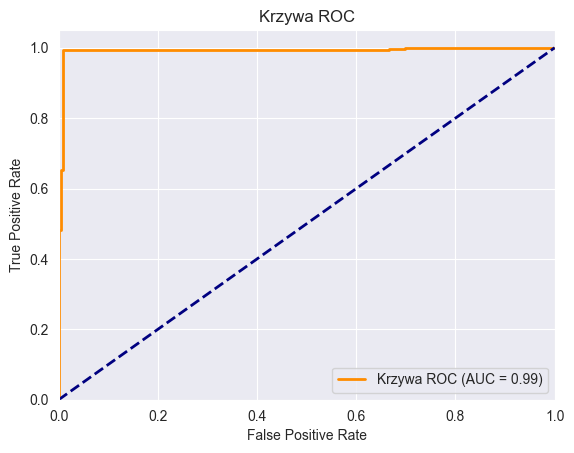

In [759]:
fpr, tpr, thresholds = roc_curve(syn1_test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

In [760]:
from sklearn.datasets import make_moons

syn2_x, syn2_y = make_moons(n_samples=n_samples, random_state=seed)
syn2_train_x, syn2_test_x, syn2_train_t, syn2_test_t = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)
syn2_test_x_k1 = syn2_test_x[syn2_test_t == 0]
syn2_test_x_k2 = syn2_test_x[syn2_test_t == 1]
syn2_train_t = [-1 if t == 0 else t for t in syn2_train_t]
syn2_test_t = [-1 if t == 0 else t for t in syn2_test_t]

zbiór 2 

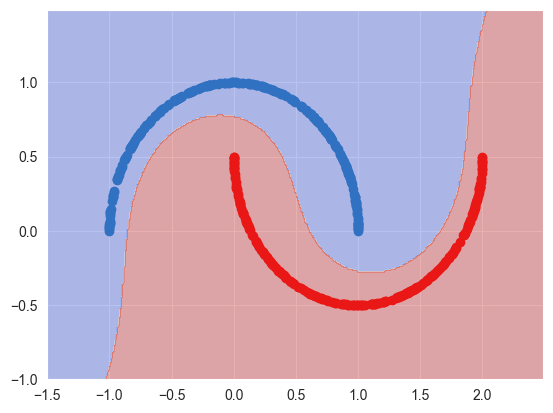

In [761]:
from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_S = poly.fit_transform(syn2_train_x)
X_poly_test_S = poly.fit_transform(syn2_test_x)
clf = RidgeClassifier(alpha=1.0).fit(X_poly_S, syn2_train_t)
syn2_test_y_S = clf.predict(X_poly_test_S)

result_S = clf.decision_function(X_poly_test_S)
xx, yy = np.meshgrid(np.arange(-1.5, 2.5, 0.01),
                     np.arange(-1.0, 1.5, 0.01))
Z = poly.transform(np.c_[xx.ravel(), yy.ravel()])
Z = clf.predict(Z)
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_k1[:,0], syn2_test_x_k1[:,1])
plt.scatter(syn2_test_x_k2[:,0], syn2_test_x_k2[:,1], c="r")
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.show()
syn1_test_y_S = clf.predict(X_poly_test_S)

[-5.67632549 -5.52151345 -5.36831534 ...  5.115789    5.26669708
  5.41921078]


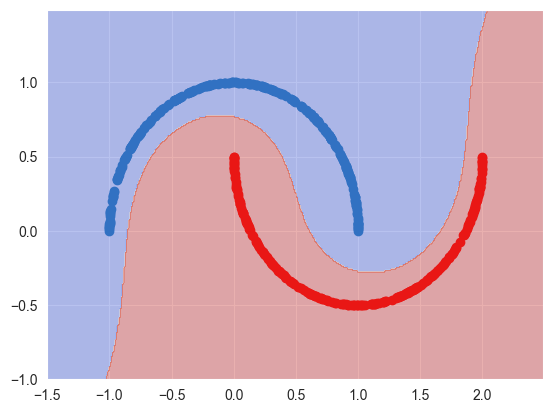

In [762]:
ALFA = 1.0


poly = PolynomialFeatures(degree=3, include_bias=True)
X = poly.fit_transform(syn2_train_x)
X_test = poly.fit_transform(syn2_test_x)


d = X.shape[1]
A = ALFA*np.identity(d)
teta_A = np.linalg.inv(X.T@X+A)@X.T@syn2_train_t

syn1_test_y_A = []
result_A = X_test@teta_A

syn2_test_y_A = [-1 if res <= 0 else 1 for res in result_A]


xx, yy = np.meshgrid(np.arange(-1.5, 2.5, 0.01),
                     np.arange(-1.0, 1.5, 0.01))
Z = poly.transform(np.c_[xx.ravel(), yy.ravel()])
Z_P = Z@teta_A
print(Z_P)
Z = np.array([-1 if res <= 0 else 1 for res in Z_P])
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_k1[:,0], syn2_test_x_k1[:,1])
plt.scatter(syn2_test_x_k2[:,0], syn2_test_x_k2[:,1], c="r")
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.show()

Macierz pomyłek dla Sklearn

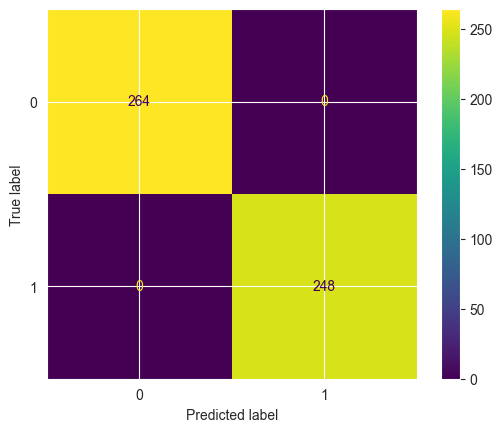

In [763]:
cm_S = confusion_matrix(syn2_test_t, syn2_test_y_S)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

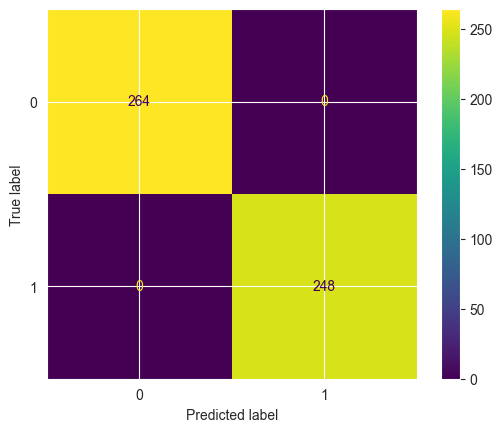

In [764]:
cm_A = confusion_matrix(syn2_test_t, syn2_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [765]:
TP = cm_S[1, 1]  # True Positive
FN = cm_S[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TP = cm_A[1, 1]  # True Positive
FN = cm_A[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TN = cm_S[0, 0]  # True Negative
FP = cm_S[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

TN = cm_A[0, 0]  # True Negative
FP = cm_A[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

1.0
1.0
1.0
1.0


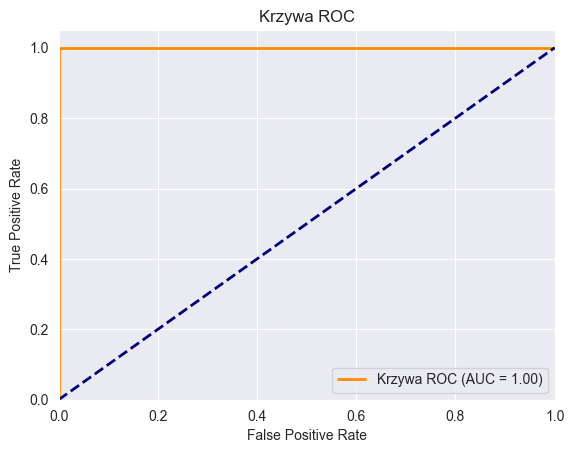

In [766]:
fpr, tpr, thresholds = roc_curve(syn2_test_t, result_S)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

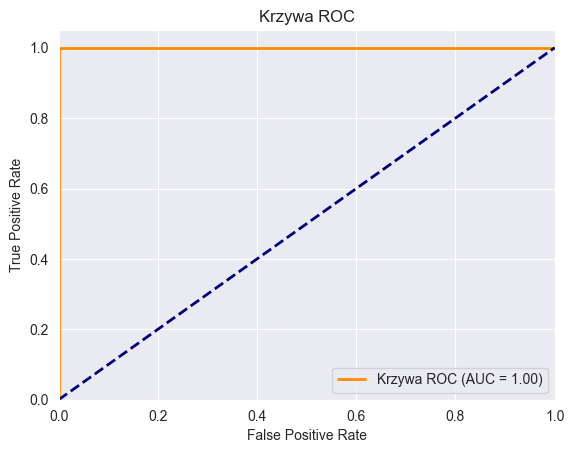

In [767]:
fpr, tpr, thresholds = roc_curve(syn2_test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

In [768]:
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fps', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
heart_data = pd.read_csv('HeartCleveland.csv', names=column_names, na_values=['?'])
heart_data.head()

,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [769]:
heart_data.isna().sum()
heart_data.dropna(inplace=True)

In [770]:
heart_data.describe()

,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [771]:
heart_data.num.clip(upper=1, inplace=True)
heart_data.head()

C:\Users\marci\AppData\Local\Temp\ipykernel_20288\586649917.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  heart_data.num.clip(upper=1, inplace=True)


,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [772]:
continuous_vars = ['trestbps', 'chol', 'thalach', 'oldpeak']
heart_data[continuous_vars].describe()

,trestbps,chol,thalach,oldpeak
count,297.000000,297.000000,297.000000,297.000000
mean,131.693603,247.350168,149.599327,1.055556
std,17.762806,51.997583,22.941562,1.166123
min,94.000000,126.000000,71.000000,0.000000
25%,120.000000,211.000000,133.000000,0.000000
50%,130.000000,243.000000,153.000000,0.800000
75%,140.000000,276.000000,166.000000,1.600000
max,200.000000,564.000000,202.000000,6.200000


In [773]:
discrete_vars = ['age', 'ca']
heart_data[discrete_vars].describe()

,age,ca
count,297.000000,297.000000
mean,54.542088,0.676768
std,9.049736,0.938965
min,29.000000,0.000000
25%,48.000000,0.000000
50%,56.000000,0.000000
75%,61.000000,1.000000
max,77.000000,3.000000


In [774]:
categorical_vars = ['sex', 'cp', 'fps', 'restecg', 'exang', 'slope', 'thal']
df = heart_data[categorical_vars].describe(percentiles=[]).loc[['min', 'max']]
df

,sex,cp,fps,restecg,exang,slope,thal
min,0.0,1.0,0.0,0.0,0.0,1.0,3.0
max,1.0,4.0,1.0,2.0,1.0,3.0,7.0


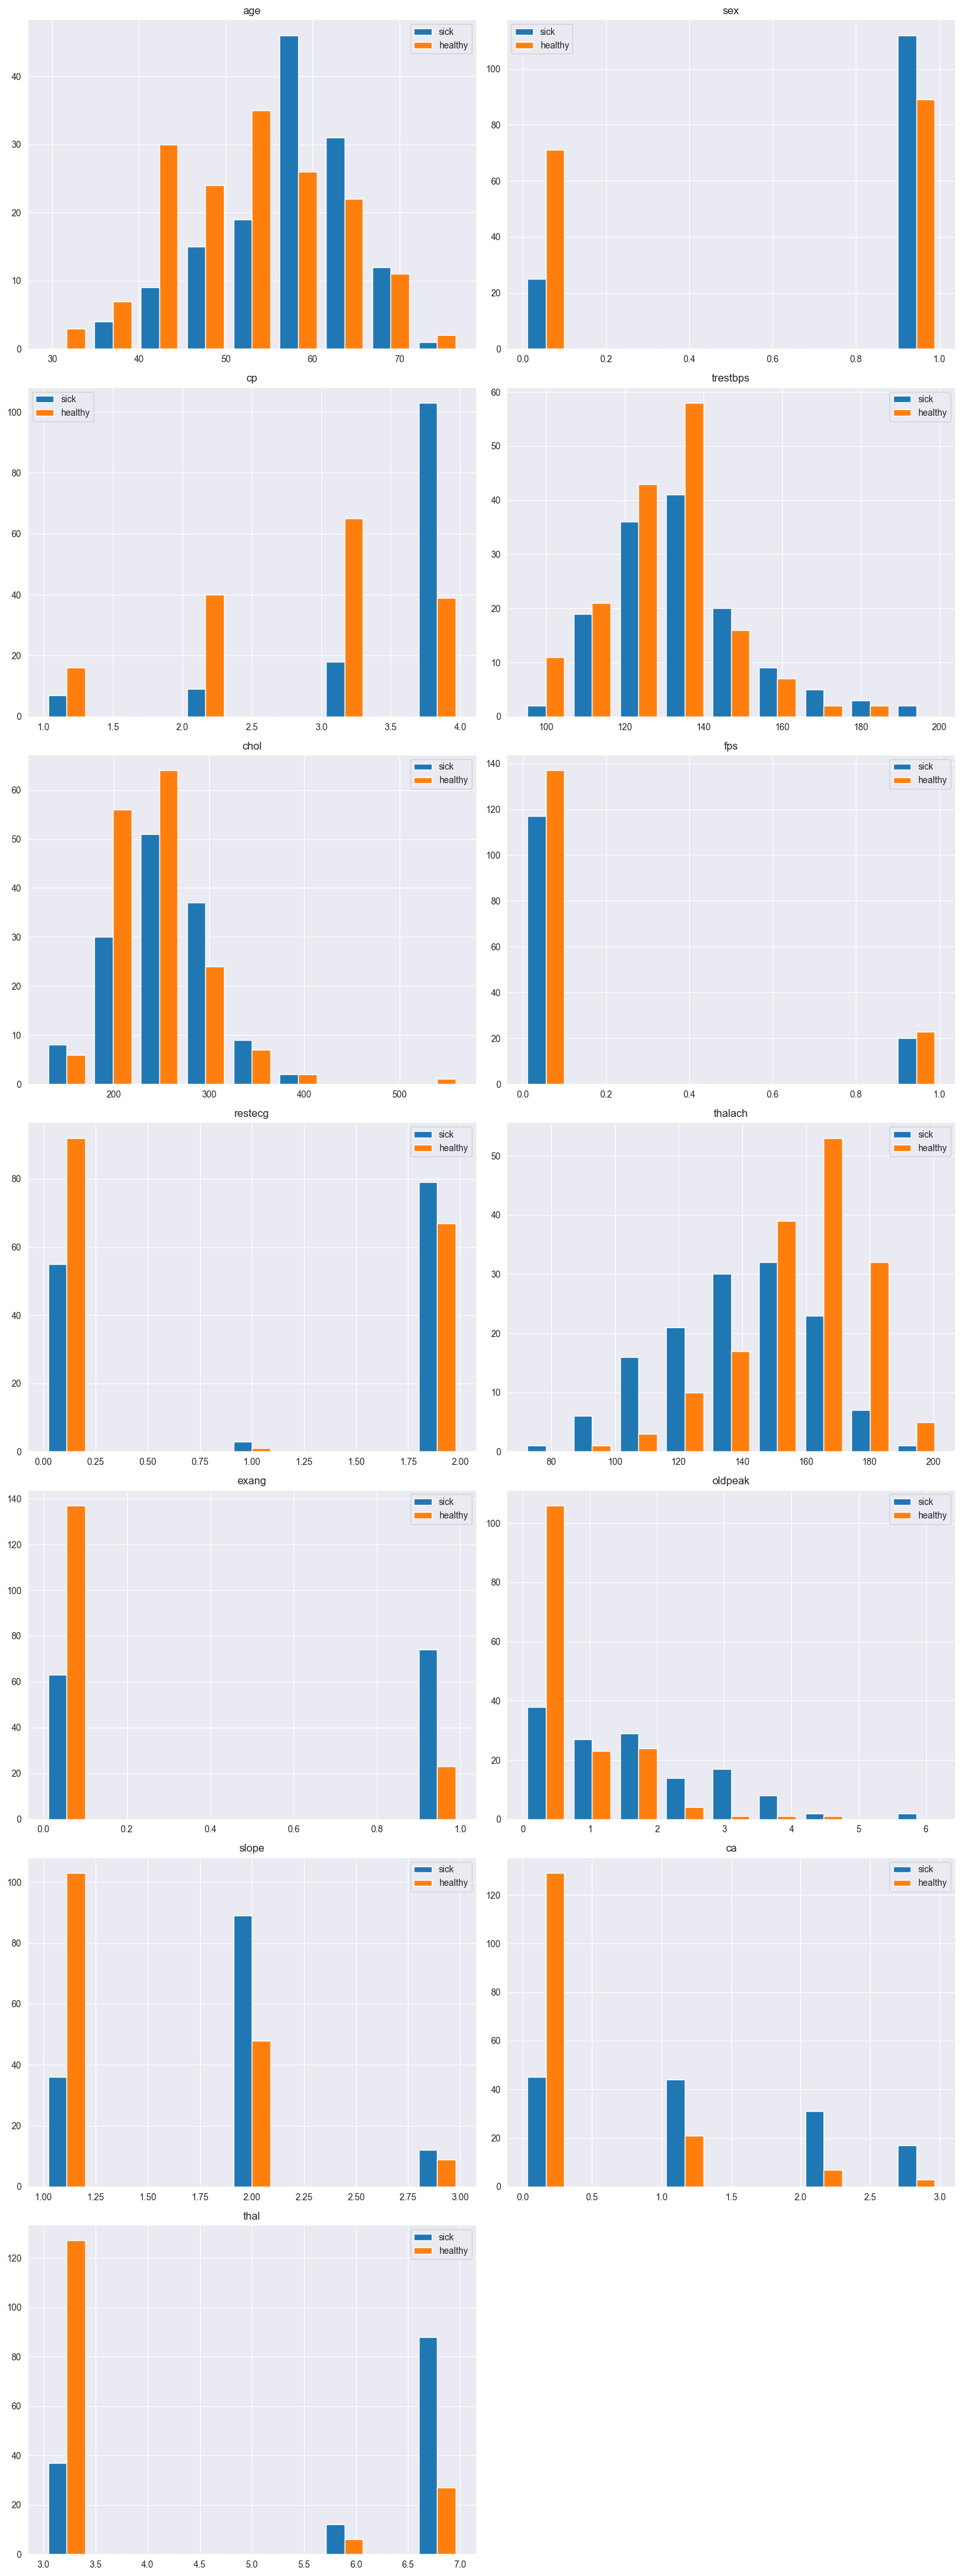

In [775]:
import seaborn as sns
features_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fps', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
sns.set_style("darkgrid")

heart_data_sick = heart_data.loc[heart_data['num'] == 1]
heart_data_healthy = heart_data.loc[heart_data['num'] == 0]
fig, axs = plt.subplots(7, 2, figsize=(15, 40))
fig.delaxes(axs[6, 1])


for i, feature in enumerate(features_names):
    ax = axs[i//2][i%2]
    maxx =max(heart_data_sick[feature].max(), heart_data_healthy[feature].max())
    minn = min(heart_data_sick[feature].min(), heart_data_healthy[feature].min())

    bins = np.linspace(minn, maxx, 10)
    ax.hist([heart_data_sick[feature], heart_data_healthy[feature]], bins, label=['sick', 'healthy'])
    ax.set_title(feature)
    ax.legend()

fig.tight_layout()

(14, 14)


<Axes: >

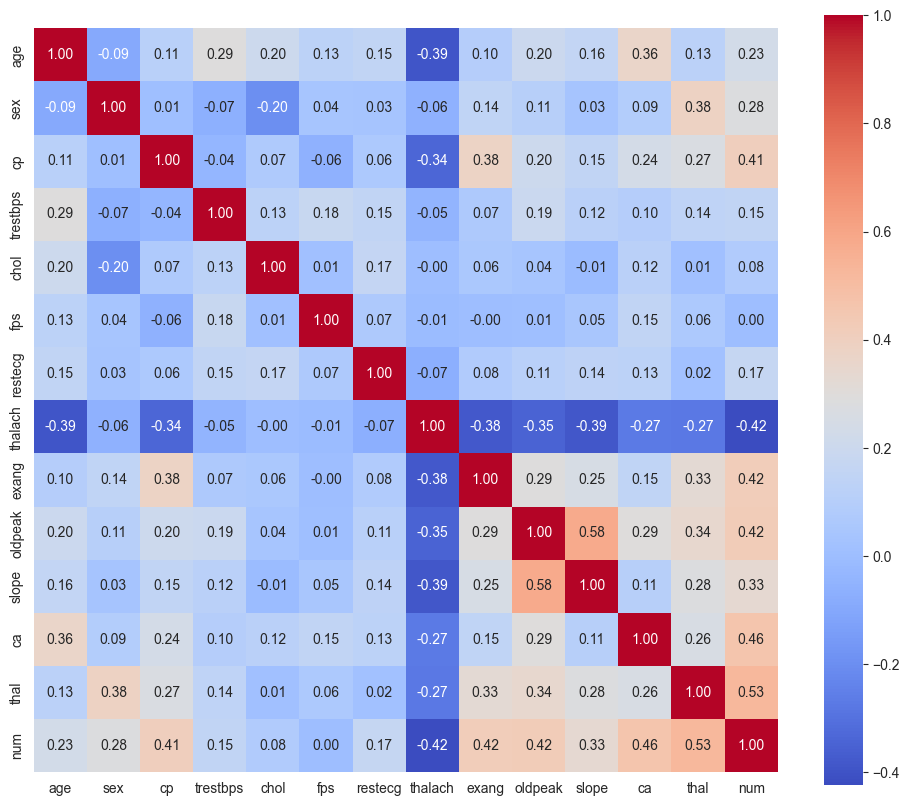

In [776]:
correlation_matrix = heart_data.corr()
print(correlation_matrix.shape)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

In [777]:
biggest_corelations = correlation_matrix["num"].sort_values(key=abs, ascending=False)
print(biggest_corelations[:][1:5])

thal       0.526640
ca         0.463189
oldpeak    0.424052
thalach   -0.423817
Name: num, dtype: float64


In [778]:
train_x, test_x, train_t, test_t = train_test_split(heart_data.iloc[:, :-1], heart_data.iloc[:, -1], test_size=.2, random_state=seed)
train_t = train_t.values
test_t = test_t.values
train_t = np.array([-1 if t == 0 else t for t in train_t])
test_t = np.array([-1 if t == 0 else t for t in test_t])
train_x = np.array(train_x)
test_x = np.array(test_x)

In [779]:
clf = RidgeClassifier(alpha=1.0).fit(train_x, train_t)
result_S = clf.decision_function(test_x)
syn_test_y_S =clf.predict(test_x)

In [780]:
ALFA = 1.0

num_rows = train_x.shape[0]
ones_column = np.ones((num_rows, 1))
X = np.hstack((ones_column, train_x))
d = X.shape[1]
A = ALFA*np.identity(d)
teta_A = np.linalg.inv(X.T@X+A)@X.T@train_t

num_rows = test_x.shape[0]
ones_column = np.ones((num_rows, 1))
X_test = np.hstack((ones_column, test_x))

result_A = X_test@teta_A
syn1_test_y_A = np.array([-1 if res <= 0 else 1 for res in result_A])

Macierz pomyłek sklearn

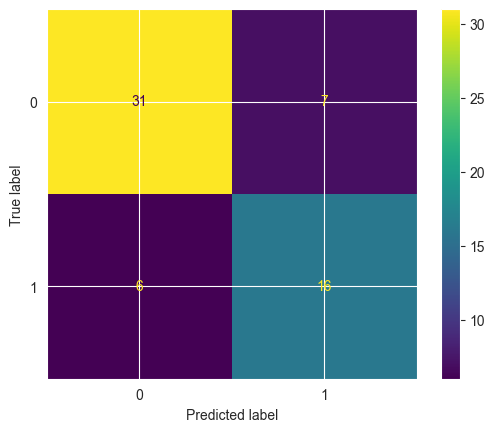

In [781]:
cm_S = confusion_matrix(test_t, syn_test_y_S)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

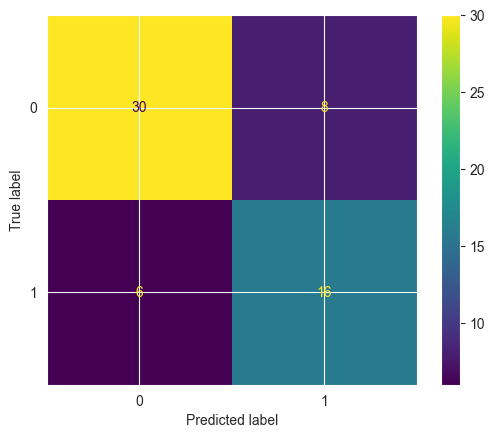

In [782]:
cm_A = confusion_matrix(test_t, syn1_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [783]:
TP = cm_S[1, 1]  # True Positive
FN = cm_S[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TP = cm_A[1, 1]  # True Positive
FN = cm_A[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TN = cm_S[0, 0]  # True Negative
FP = cm_S[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

TN = cm_A[0, 0]  # True Negative
FP = cm_A[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

0.7272727272727273
0.7272727272727273
0.8157894736842105
0.7894736842105263


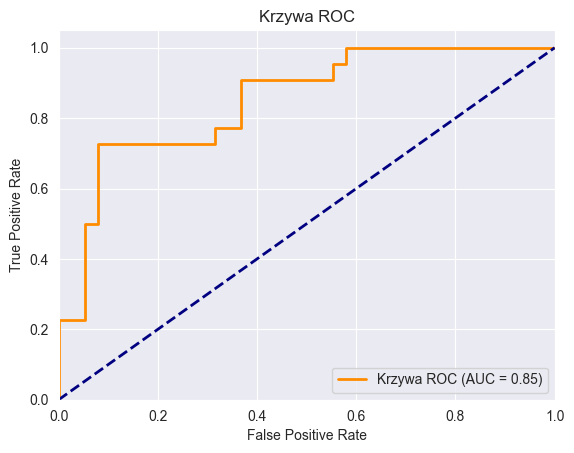

In [784]:
fpr, tpr, thresholds = roc_curve(test_t, result_S)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

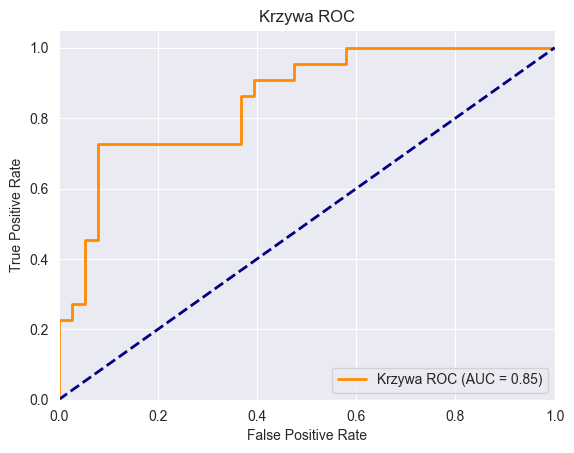

In [785]:
fpr, tpr, thresholds = roc_curve(test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

In [786]:
four_best = ["thal", "ca", "oldpeak", "thalach", "num"]
heart_data_four_np =  np.array(heart_data[four_best])
train_x, test_x, train_t, test_t = train_test_split(heart_data_four_np[:, :-1], heart_data_four_np[:, -1], test_size=.2, random_state=seed)
train_t = np.array([-1 if t == 0 else t for t in train_t])
test_t = np.array([-1 if t == 0 else t for t in test_t])

In [787]:
clf = RidgeClassifier(alpha=1.0).fit(train_x, train_t)
result_S = clf.decision_function(test_x)
syn_test_y_S =clf.predict(test_x)

In [788]:
ALFA = 1.0

num_rows = train_x.shape[0]
ones_column = np.ones((num_rows, 1))
X = np.hstack((ones_column, train_x))
d = X.shape[1]
A = ALFA*np.identity(d)
teta_A = np.linalg.inv(X.T@X+A)@X.T@train_t

num_rows = test_x.shape[0]
ones_column = np.ones((num_rows, 1))
X_test = np.hstack((ones_column, test_x))

result_A = X_test@teta_A
syn1_test_y_A = np.array([-1 if res <= 0 else 1 for res in result_A])

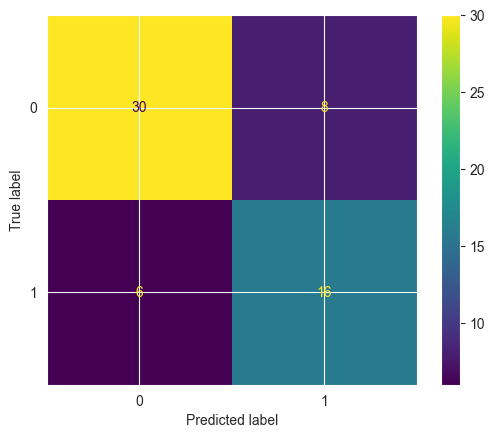

In [789]:
cm_S = confusion_matrix(test_t, syn_test_y_S)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

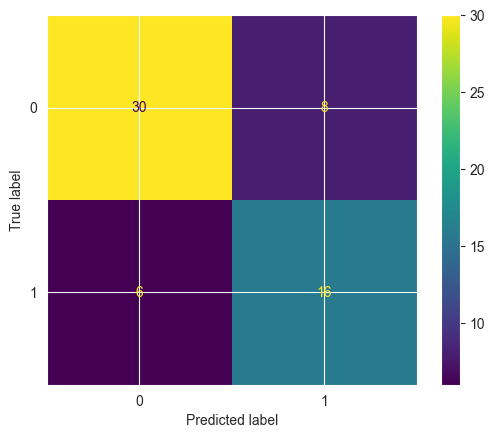

In [790]:
cm_A = confusion_matrix(test_t, syn1_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [791]:
TP = cm_S[1, 1]  # True Positive
FN = cm_S[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TP = cm_A[1, 1]  # True Positive
FN = cm_A[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TN = cm_S[0, 0]  # True Negative
FP = cm_S[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

TN = cm_A[0, 0]  # True Negative
FP = cm_A[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

0.7272727272727273
0.7272727272727273
0.7894736842105263
0.7894736842105263


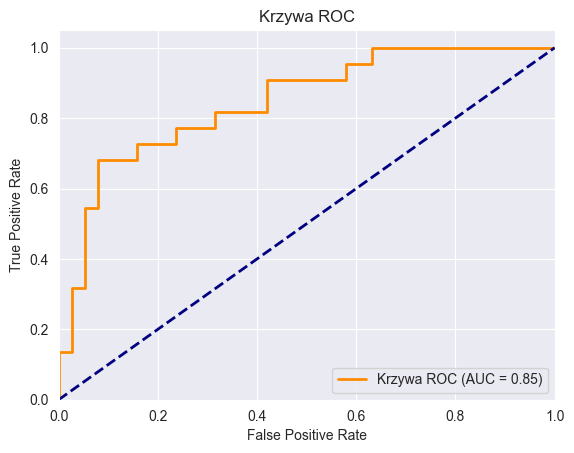

In [792]:
fpr, tpr, thresholds = roc_curve(test_t, result_S)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

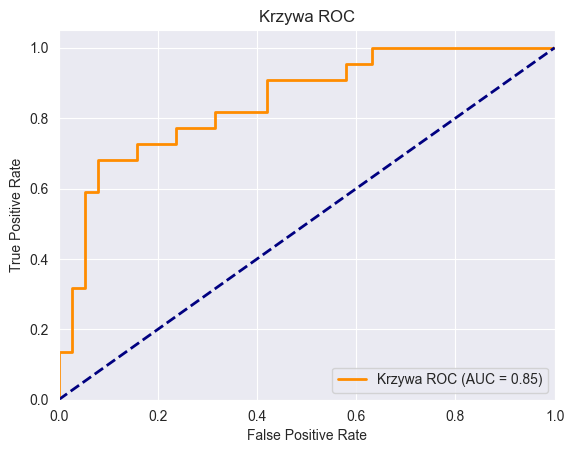

In [793]:
fpr, tpr, thresholds = roc_curve(test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

In [794]:
heart_data_four_np =  np.array(heart_data)
train_x, test_x, train_t, test_t = train_test_split(heart_data_four_np[:, :-1], heart_data_four_np[:, -1], test_size=.2, random_state=seed)
train_t = np.array([-1 if t == 0 else t for t in train_t])
test_t = np.array([-1 if t == 0 else t for t in test_t])
heart_data.head()

,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [795]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
column_names = np.array(['age', 'sex', 'cp', 'trestbps', 'chol', 'fps', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'])

classifier = RidgeClassifier(alpha=1.0)
selector = SequentialFeatureSelector(classifier, n_features_to_select=4)
selector.fit(train_x, train_t)
print(column_names[selector.get_support()])

['restecg' 'oldpeak' 'ca' 'thal']


In [796]:
four_best = ["restecg", "oldpeak", "ca", "thal", "num"]
heart_data_four_np =  np.array(heart_data[four_best])
train_x, test_x, train_t, test_t = train_test_split(heart_data_four_np[:, :-1], heart_data_four_np[:, -1], test_size=.2, random_state=seed)
train_t = np.array([-1 if t == 0 else 1 for t in train_t])
test_t = np.array([-1 if t == 0 else 1 for t in test_t])

In [797]:
clf = RidgeClassifier(alpha=1.0).fit(train_x, train_t)
result_S = clf.decision_function(test_x)
syn_test_y_S =clf.predict(test_x)

In [798]:
ALFA = 1.0

num_rows = train_x.shape[0]
ones_column = np.ones((num_rows, 1))
X = np.hstack((ones_column, train_x))
d = X.shape[1]
A = ALFA*np.identity(d)
teta_A = np.linalg.inv(X.T@X+A)@X.T@train_t

num_rows = test_x.shape[0]
ones_column = np.ones((num_rows, 1))
X_test = np.hstack((ones_column, test_x))

result_A = X_test@teta_A
syn1_test_y_A = np.array([-1 if res <= 0 else 1 for res in result_A])

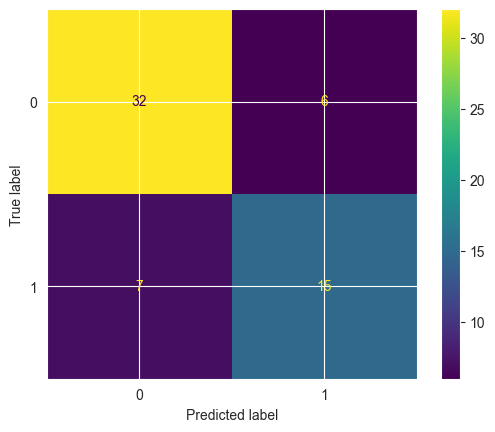

In [799]:
cm_S = confusion_matrix(test_t, syn_test_y_S)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

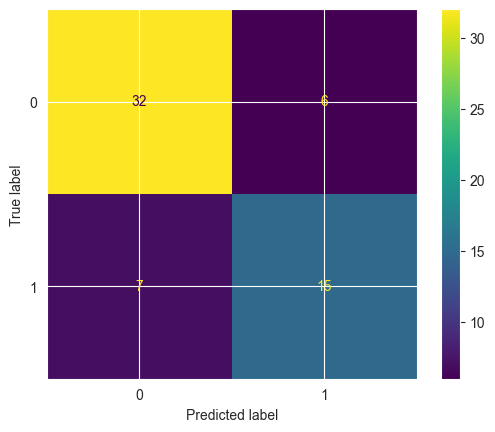

In [800]:
cm_A = confusion_matrix(test_t, syn1_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [801]:
TP = cm_S[1, 1]  # True Positive
FN = cm_S[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TP = cm_A[1, 1]  # True Positive
FN = cm_A[1, 0]  # False Negative
sensitivity = TP / (TP + FN)
print(sensitivity)

TN = cm_S[0, 0]  # True Negative
FP = cm_S[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

TN = cm_A[0, 0]  # True Negative
FP = cm_A[0, 1]  # False Positive
specificity = TN / (TN + FP)
print(specificity)

0.6818181818181818
0.6818181818181818
0.8421052631578947
0.8421052631578947


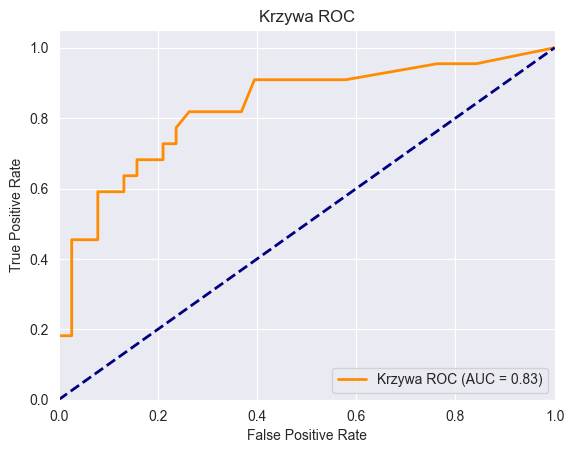

In [802]:
fpr, tpr, thresholds = roc_curve(test_t, result_S)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

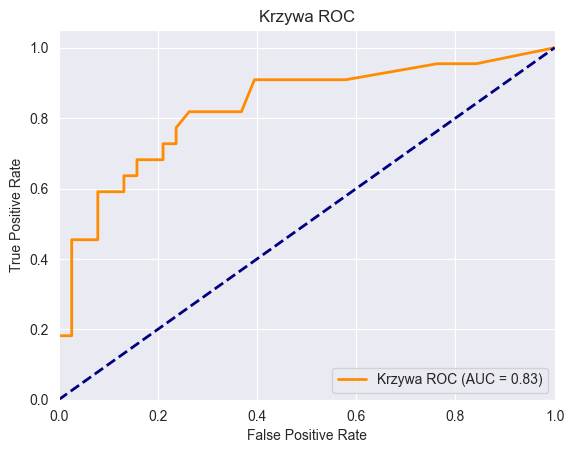

In [803]:
fpr, tpr, thresholds = roc_curve(test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()